# Time of day analysis of criminal offenses

In this notebook I perform a simple analysis of the variation of criminal offenses as a function of the time of day, using R. This is an assignment for the online course Practical Predictive Analytics: Models and Methods and its main purpose is to showcase the use of plots to convey information. The data comes from two separate data sets, one corresponding to San Francisco and the other to Seattle. Both cover the period of Summer 2014.

## San Francisco data

I will work first with the San Francisco data and begin by calling the `summary` and `str` functions. Below I have commented the former to reduce the output.

In [1]:
sanfran<-read.csv("sanfrancisco_incidents_summer_2014.csv", na.strings = c(""))
# summary(sanfran)
str(sanfran)

'data.frame':	28993 obs. of  13 variables:
 $ IncidntNum: int  140734311 140736317 146177923 146177531 140734220 140734349 140734349 140734349 140738147 140734258 ...
 $ Category  : Factor w/ 34 levels "ARSON","ASSAULT",..: 1 20 16 16 20 7 7 6 21 30 ...
 $ Descript  : Factor w/ 368 levels "ABANDONMENT OF CHILD",..: 16 179 143 143 132 242 234 93 107 347 ...
 $ DayOfWeek : Factor w/ 7 levels "Friday","Monday",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Date      : Factor w/ 92 levels "06/01/2014","06/02/2014",..: 92 92 92 92 92 92 92 92 92 92 ...
 $ Time      : Factor w/ 1379 levels "00:01","00:02",..: 1370 1365 1351 1351 1344 1334 1334 1334 1321 1321 ...
 $ PdDistrict: Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 1 4 8 7 7 8 8 8 3 2 ...
 $ Resolution: Factor w/ 16 levels "ARREST, BOOKED",..: 12 12 12 12 12 1 1 1 12 2 ...
 $ Address   : Factor w/ 8055 levels "0 Block of 10TH ST",..: 6843 4039 676 6111 5097 1263 1263 1263 1575 5236 ...
 $ X         : num  -122 -122 -122 -122 -123 ...
 $ Y         : num

Notice that the time was read as a factor data type, so I will convert it to a time format and create a new column which stores the hour, truncating the minutes.

In [2]:
sanfran$Hour<-strptime(sanfran$Time, "%H") # Converts to time format. Truncates minutes.
# At this moment the time is stored in seconds since a default date.
# Convert to seconds since midnight (remove date information)
sanfran$Hour<-as.numeric(sanfran$Hour- trunc(sanfran$Hour, "days"))
# Convert to whole hours.
sanfran$Hour<-as.integer(floor(sanfran$Hour/3600))

Now as a quick exploration, I will determine the most common offenses by counting the total number of each type and ordering them. In order to keep a moderate output, I only show the top 10.

In [3]:
offenses<-summary(sanfran$Category)
off_ordering<-order(offenses, decreasing=TRUE)
offenses<-offenses[off_ordering]
print(offenses[1:10])

  LARCENY/THEFT  OTHER OFFENSES    NON-CRIMINAL         ASSAULT   VEHICLE THEFT 
           9466            3567            3023            2882            1966 
       WARRANTS   DRUG/NARCOTIC  SUSPICIOUS OCC  MISSING PERSON SECONDARY CODES 
           1782            1345            1300            1266             442 


I will study some of the offenses with the largest sample size. In particular I am interested in seeing how they are distributed throughout the day and whether we can classify them based on this.

In order to achieve this I will start by binning the times in 3 hour intervals. Other intervals work, but this is the smallest I found that displays the data clearly. The code can be modified to a different number of bins by changing the variable nhours to the desired value. The intervals are indexed the following way: 0 means 00:00 to 02:59 and so forth.

In [4]:
# Bin the hours in intervals of nhours hours (must be a divisor of 24).
nhours<-3
bins<-0:(23/nhours)*nhours
sanfran$Hour.bin<-nhours*floor(sanfran$Hour/nhours)

The next step is to find the total number of offences of each kind per time interval.

In [5]:
# Create a matrix of offense/Time of day
offenset_t<-tapply(sanfran$Category, list(sanfran$Hour.bin, sanfran$Category), length)
# Replace NAs by 0
for (x in 1:(24/nhours)) {
    offenset_t[x, is.na(offenset_t[x,])]<-0
}
# print (offenset_t)

I normalized the data in order to compare different types of offense meaningfully. Specifically, for each offense type, I divided all bins by the total number of offenses of that type. This way I obtain a probability distribution that shows, given an offense of a particular type, the probability of that occuring at each time interval.

In [6]:
# Normalize: For each offense type, divide the data by the total number of offenses of that type.
for (x in 1:length(offenset_t[1, ]) ) {
    total<-sum(offenset_t[ ,x])
    offenset_t[ ,x]<-offenset_t[ ,x]/total
}

In order to facilitate plotting these distributions, I created two data frames with a small subset of the data.

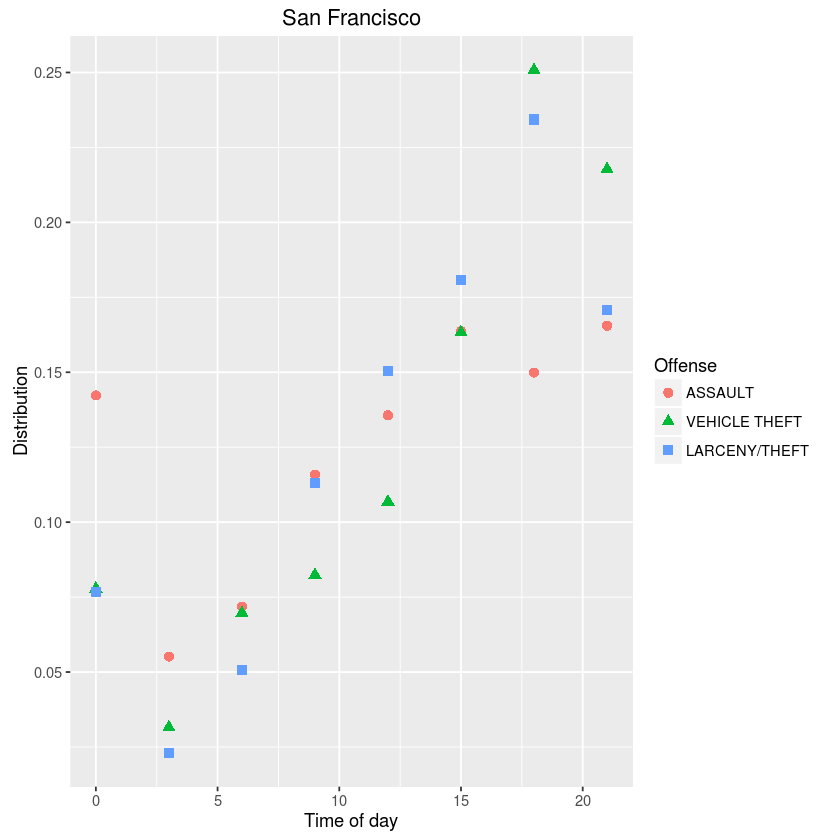

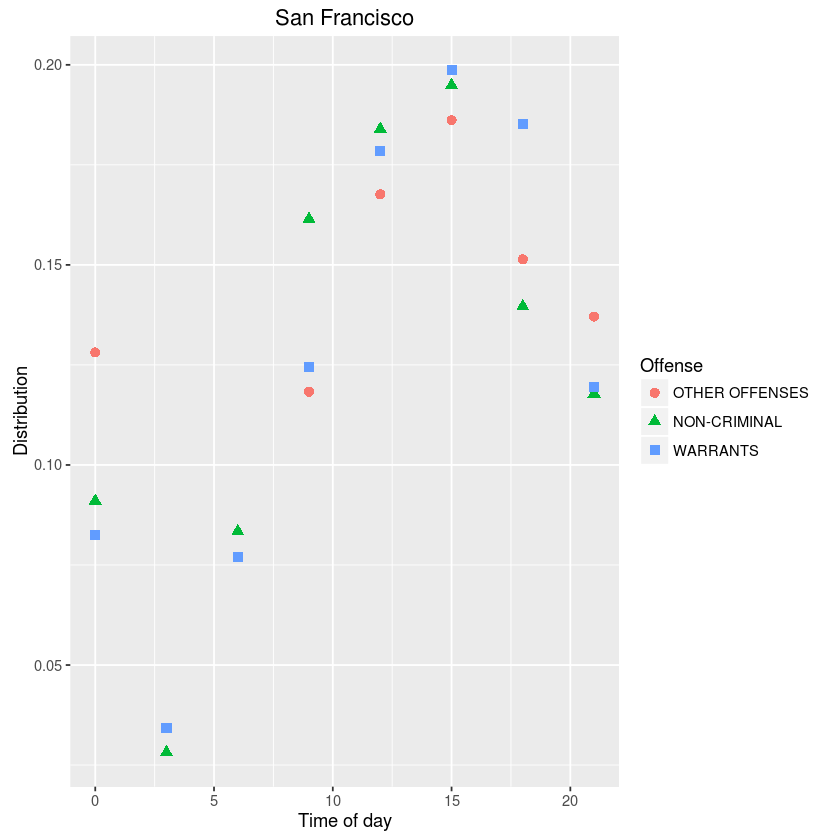

In [7]:
# Arrange into data frame
crime<-data.frame(Number=offenset_t[ ,"ASSAULT"], Hour=bins, Offense=rep("ASSAULT", length(bins)))
crime<-rbind(crime, data.frame(Number=offenset_t[ ,"VEHICLE THEFT"], Hour=bins, Offense=rep("VEHICLE THEFT", length(bins))))
crime<-rbind(crime, data.frame(Number=offenset_t[ ,"LARCENY/THEFT"], Hour=bins, Offense=rep("LARCENY/THEFT", length(bins))))

crime2<-data.frame(Number=offenset_t[ ,"OTHER OFFENSES"], Hour=bins, Offense=rep("OTHER OFFENSES", length(bins)))
crime2<-rbind(crime2, data.frame(Number=offenset_t[ ,"NON-CRIMINAL"], Hour=bins, Offense=rep("NON-CRIMINAL", length(bins))))
crime2<-rbind(crime2, data.frame(Number=offenset_t[ ,"WARRANTS"], Hour=bins, Offense=rep("WARRANTS", length(bins))))

# Create plots using ggplot2
library(ggplot2)
ggplot(crime, aes(x=Hour, y=Number)) + geom_point(aes(color=Offense, shape=Offense), size=2.5) +xlab("Time of day") +ylab("Distribution") +ggtitle("San Francisco")
ggplot(crime2, aes(x=Hour, y=Number)) + geom_point(aes(color=Offense, shape=Offense), size=2.5) +xlab("Time of day") +ylab("Distribution") +ggtitle("San Francisco")

In these plots, I show the probability distribution for the 6 most frequent offenses, separated in two groups. The distributions in the two plots are very similar. The offenses tend to occurr much less in the 3-6 AM interval and increase after this point. However, an important difference is that in the first plot the probabilities is roughly peaked in the evening (6-9 PM), while in the second one the peak is in the late afternoon (3-6 PM). Based on this we could roughly classify the first set as "Evening" and the second as "Late afternoon".

# Seattle data

At this point an interesting question we can ask is whether this classification works in Seattle and whether the same types of offenses will receive the same classification. As we will see soon, the Seattle data does not have the same schema, i.e., the information is presented in a different way and the definition of the offenses may not be the same, which makes the task more difficult. However, some conclusions can still be drawn.

I begin by looking at the structure of the Seattle data.

In [8]:
seattle<-read.csv("seattle_incidents_summer_2014.csv", na.strings = c(""))
# summary(seattle)
str(seattle)

'data.frame':	32779 obs. of  19 variables:
 $ RMS.CDW.ID                       : int  483839 481252 481375 481690 478198 480485 470170 465137 461710 456091 ...
 $ General.Offense.Number           : num  2.02e+09 2.02e+09 2.02e+09 2.02e+09 2.02e+09 ...
 $ Offense.Code                     : Factor w/ 92 levels "1201","1202",..: 19 42 31 37 32 30 30 38 42 39 ...
 $ Offense.Code.Extension           : int  0 0 0 0 3 0 0 0 0 1 ...
 $ Offense.Type                     : Factor w/ 147 levels "ANIMAL-BITE",..: 14 42 120 19 122 116 116 41 42 39 ...
 $ Summary.Offense.Code             : Factor w/ 26 levels "1200","1300",..: 3 8 5 7 5 5 5 8 8 8 ...
 $ Summarized.Offense.Description   : Factor w/ 48 levels "ANIMAL COMPLAINT",..: 5 19 26 8 29 29 29 19 19 19 ...
 $ Date.Reported                    : Factor w/ 15766 levels "01/02/2015 11:12:00 AM",..: 4720 3991 3617 3468 3304 3125 629 39 38 36 ...
 $ Occurred.Date.or.Date.Range.Start: Factor w/ 11557 levels "06/01/2014 01:00:00 AM",..: 3526 116 11508 2

In this set, instead of a single time of the incident we are sometimes given a beginning and ending time, which makes comparing the two data sets difficult. The simple solution I chose was to ignore the latter and assume that the error of using the former is reduced by the use of bins for the time intervals. It is hard to understand the meaning of the ending time because sometimes it is months appart from the beginning time.

An additional, but small complication is that the date and time are combined in the same column, so I had to separate them first.

In [9]:
# Extract the times (in one hour bins)
seattle$Hour<- strptime(seattle$Occurred.Date.or.Date.Range.Start, "%m/%d/%Y %I:%M:%S %p") # Converts to time format.
# Convert to seconds since midnight.
seattle$Hour<-as.numeric(seattle$Hour- trunc(seattle$Hour, "days"))
seattle$Hour<-as.integer(floor(seattle$Hour/3600))

Again, I order the offenses by frequency. In contrast with the San Francisco data, the data here is divided in sub-categories. For example, each type of theft is listed separately (carprowl, shoplift, and so forth). I show the top 15 offenses to illustrate this.

In [10]:
# Order offenses by frequency (decreasing)
offenses<-summary(seattle$Offense.Type)
off_ordering<-order(offenses, decreasing=TRUE)
offenses<-offenses[off_ordering]
print(offenses[1:15])

                THEFT-CARPROWL                 VEH-THEFT-AUTO 
                          6230                           2588 
                     THEFT-OTH PROPERTY DAMAGE-NON RESIDENTIA 
                          2221                           1638 
                  ASSLT-NONAGG                DISTURBANCE-OTH 
                          1320                           1295 
            BURGLARY-FORCE-RES           BURGLARY-NOFORCE-RES 
                          1147                           1118 
                PROPERTY FOUND                 THEFT-SHOPLIFT 
                          1069                            944 
                THEFT-BUILDING                  THEFT-BICYCLE 
                           846                            797 
                WARRARR-FELONY          BURGLARY-FORCE-NONRES 
                           565                            524 
                    HARASSMENT 
                           523 


For a better comparison with San Francisco, I will remove the sub-classification for the most common offenses and recalculate the top 10.

In [11]:
# For comparison with San Francisco, collapse some of the categories.
seattle$Offense.Type<-as.character(seattle$Offense.Type)
for (x in 1:length(seattle$Offense.Type)) {
    if (grepl("VEH-THEFT", seattle$Offense.Type[x])) {
        seattle$Category[x]<-"VEH-THEFT"
    } else if (grepl("THEFT", seattle$Offense.Type[x])) {
        seattle$Category[x]<-"THEFT"
    } else if (grepl("ASSLT", seattle$Offense.Type[x])) {
        seattle$Category[x]<-"ASSAULT"
    } else if (grepl("BURGLARY", seattle$Offense.Type[x])) {
        seattle$Category[x]<-"BURGLARY"
    } else if (grepl("WARRA", seattle$Offense.Type[x])) {
        seattle$Category[x]<-"WARRANT"
    } else if (grepl("DISTURBANCE", seattle$Offense.Type[x])) {
        seattle$Category[x]<-"DISTURBANCE"
    } else if (grepl("PROPERTY DAMAGE", seattle$Offense.Type[x])) {
        seattle$Category[x]<-"PROPERTY DAMAGE"
    } else {
        seattle$Category[x]<-seattle$Offense.Type[x]
    }
}
seattle$Category<-as.factor(seattle$Category)

# Order new set of offenses by frequency (decreasing)
offenses<-summary(seattle$Category)
off_ordering<-order(offenses, decreasing=TRUE)
offenses<-offenses[off_ordering]
print(offenses[1:10])

          THEFT        BURGLARY       VEH-THEFT PROPERTY DAMAGE         ASSAULT 
          12715            3600            2871            2365            1996 
    DISTURBANCE  PROPERTY FOUND         WARRANT      HARASSMENT        TRESPASS 
           1333            1069            1021             523             486 


The most frequent offenses are not exactly the same as in San Francisco, which may be either because of an actual difference between the cities or because the classification that is being used is not the same. Perhaps even a combination of both.

To proceed, I will again bin the time in intervals of 3 hours, calculate the number of offenses per type, per time interval, normalized the data, and plot the 6 most common offenses. I also included the type "warrant" because it was included in the San Francisco plots and will give us another point of comparison.

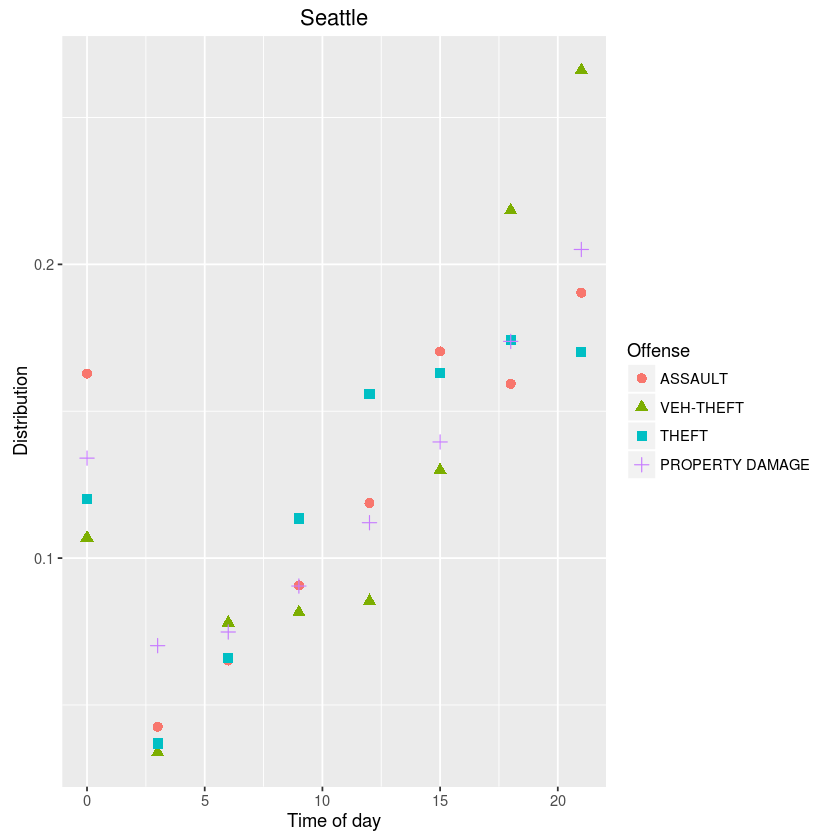

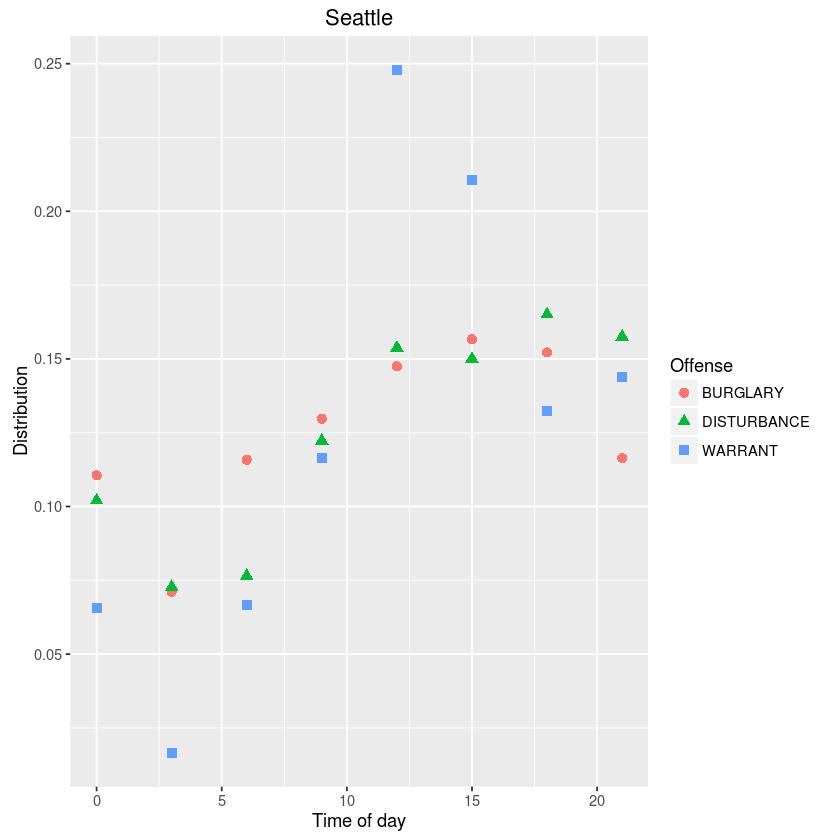

In [12]:
# Bin the hours in intervals of nhours hours (must be a divisor of 24).
nhours<-3
bins<-0:(23/nhours)*nhours
seattle$Hour.bin<-nhours*floor(seattle$Hour/nhours)

# Create a matrix of offense/Time of day
offenset_t<-tapply(seattle$Category, list(seattle$Hour.bin, seattle$Category), length)
# Replace NAs by 0
for (x in 1:(24/nhours)) {
    offenset_t[x, is.na(offenset_t[x,])]<-0
}

# Normalize: For each offense type, divide the data by the total number of offenses of that type.
for (x in 1:length(offenset_t[1, ]) ) {
    total<-sum(offenset_t[ ,x])
    offenset_t[ ,x]<-offenset_t[ ,x]/total
}

# Arrange into data frame
crime<-data.frame(Number=offenset_t[ ,"ASSAULT"], Hour=bins, Offense=rep("ASSAULT", length(bins)))
crime<-rbind(crime, data.frame(Number=offenset_t[ ,"VEH-THEFT"], Hour=bins, Offense=rep("VEH-THEFT", length(bins))))
crime<-rbind(crime, data.frame(Number=offenset_t[ ,"THEFT"], Hour=bins, Offense=rep("THEFT", length(bins))))
crime<-rbind(crime, data.frame(Number=offenset_t[ ,"PROPERTY DAMAGE"], Hour=bins, Offense=rep("PROPERTY DAMAGE", length(bins))))

crime2<-data.frame(Number=offenset_t[ ,"BURGLARY"], Hour=bins, Offense=rep("BURGLARY", length(bins)))
crime2<-rbind(crime2, data.frame(Number=offenset_t[ ,"DISTURBANCE"], Hour=bins, Offense=rep("DISTURBANCE", length(bins))))
crime2<-rbind(crime2, data.frame(Number=offenset_t[ ,"WARRANT"], Hour=bins, Offense=rep("WARRANT", length(bins))))

# Plot the data
library(ggplot2)
ggplot(crime, aes(x=Hour, y=Number)) + geom_point(aes(color=Offense, shape=Offense), size=2.5) +xlab("Time of day") +ylab("Distribution") +ggtitle("Seattle")
ggplot(crime2, aes(x=Hour, y=Number)) + geom_point(aes(color=Offense, shape=Offense), size=2.5) +xlab("Time of day") +ylab("Distribution") +ggtitle("Seattle")


Here I separated the data again into two groups, based on where the distributions are peaked. The "evening" offenses match the case of San Francisco (except for "property damage", which I did not include before). An important difference is that in this dataset the peaks seems to be shifted to the 9PM-12AM block. In other words, some of these offenses seem to occur later in the night than in San Francisco.

In the second plot the only comparison we can make with San Francisco is for warrants. It is easily seen that they are sharply peaked in the 12-3 PM block, instead of in the 3-6 PM block as it was in San Francisco.

# Conclusions

In this notebook I have analyzed the similarities and differences between the time-of-day distributions of the most frequent criminal offenses in San Francisco and Seattle using Summer 2014 data. For each city I qualitatively classified these offenses in two groups, depending whether the distributions were biased toward the evening or the afternoon. Comparing the two cities I highlighted the fact that the evening offenses seem to be biased toward a later time in Seattle. Also, in the specific case of warrants the bias in Seattle is toward an earlier time of day. One important caveat to keep in mind is that the date and time data for Seattle were sometimes presented with a begin-to-end format, in which case the end date was ignored to simplify the analysis.